<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Early_fusion_Effnet_lesion_based_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

## Read, Split train_val & oversample train set


In [5]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] =  dataset_images_location+'/'+df['Image name']+'.jpg'
df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade
72,/content/drive/My Drive/IDRid/B. Disease Gradi...,2
256,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
290,/content/drive/My Drive/IDRid/B. Disease Gradi...,1
311,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
389,/content/drive/My Drive/IDRid/B. Disease Gradi...,4


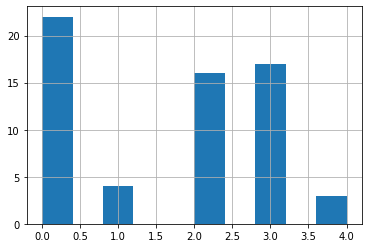

In [6]:
val_df['Retinopathy grade'].hist()

In [7]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 351


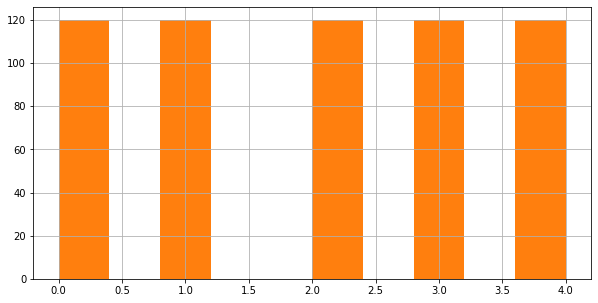

In [8]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [121]:
def crop_image_from_gray(img, tol=7):
    IMG_WIDTH=512
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            img = cv2.resize(img, (IMG_WIDTH, IMG_WIDTH))/255
        return img

In [10]:
train_df['Retinopathy grade']=train_df['Retinopathy grade'].astype('str')
val_df['Retinopathy grade'] =val_df['Retinopathy grade'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [122]:
BATCH_SIZE = 4
IMG_WIDTH, IMG_HEIGHT=512,512

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=[0.75,1],
                                   width_shift_range=1.1,
                                   height_shift_range=0.05,
                                   fill_mode='nearest',
                                   preprocessing_function= crop_image_from_gray
                                )

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE)
val_datagen = ImageDataGenerator(
                                  shear_range=0.0,
                                  zoom_range=[0.75,1],
                                  width_shift_range=1.1,
                                  height_shift_range=0.05,
                                  rotation_range=15,
                                  fill_mode='nearest',
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                 preprocessing_function= crop_image_from_gray)

val_generator = val_datagen.flow_from_dataframe(  val_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE
                                                  )

Found 600 validated image filenames belonging to 5 classes.
Found 62 validated image filenames belonging to 5 classes.


## Read test_df


In [13]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_images_location+'/'+test_df['Image name']+'.jpg'
test_df_['Retinopathy grade'] = test_df['Retinopathy grade'].astype('str')
test_df = test_df_
print(test_df.head())

                                          Image name Retinopathy grade
0  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
1  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
2  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
3  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
4  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4


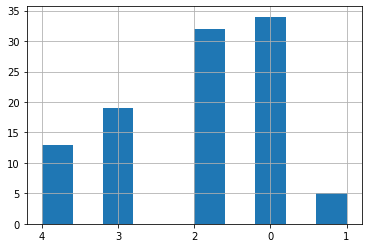

In [14]:
test_df['Retinopathy grade'].hist()

In [123]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = imread( image_name);
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32')/ np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)
enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(test_labels)
test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape)

len of test set  103
(103, 512, 512, 3)
(103, 5)


In [124]:
test_datagen = ImageDataGenerator(
                          shear_range=0.0,
                          zoom_range=[0.75,1],
                          width_shift_range=1.1,
                          height_shift_range=0.05,
                          rotation_range=15,
                          fill_mode='nearest',
                          horizontal_flip=True,
                          vertical_flip=True,
                          preprocessing_function= crop_image_from_gray)

test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=4
                                                  )

Found 103 validated image filenames belonging to 5 classes.


In [28]:
"""from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)"""

'from sklearn.utils import shuffle\ntrain_images, train_labels = shuffle(train_images, train_labels, random_state = 1)\n# If train and test are from respective sets\nprint("train x size ",train_images.shape)\nprint("train y size ",train_labels.shape)\nprint("test x size ",test_images.shape)\nprint("test y size ",test_labels.shape)\nprint("val x size ",val_images.shape)\nprint("val y size ",val_labels.shape)'

1.0


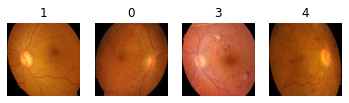

In [125]:
for i,(img,lbl) in enumerate(train_generator):
  print(np.max(img))
  for j in range(4):
    ax=plt.subplot(1,4,j+1)  
    plt.imshow(img[j]/np.max(img))
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

1.0 (4, 512, 512, 3)


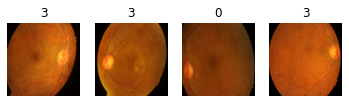

In [126]:
for i,(img,lbl) in enumerate(val_generator):
  print(np.max(img),img.shape)
  for j in range(4):
    ax=plt.subplot(1,4,j+1)  
    plt.imshow(img[j]/np.max(img))
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

1.0 (4, 512, 512, 3)


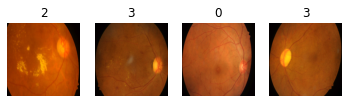

In [127]:
for i,(img,lbl) in enumerate(test_generator):
  print(np.max(img),img.shape)
  for j in range(4):
    ax=plt.subplot(1,4,j+1)  
    plt.imshow(img[j]/np.max(img))
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

In [17]:
from keras.models import Sequential
#from tensorflow.keras.applications import EfficientNetB0,EfficientNetB4
#from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [18]:
from tensorflow.keras.models import model_from_json
def load_seg_model(model_name):
    """
    loads the pretrained seg model of given lesion
    """
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/{}.h5".format(model_name))
    # print("Loaded model from disk")

    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [45]:
def build_model(num_classes,input_size):
    random.seed = 1337
    tf.seed = 1337
    tf.random.set_seed(1337)
    IMG_SIZE=input_size#680
    NUM_CLASSES=num_classes
    # define inputs
    input_0 = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    #input_1 = tf.keras.layers.experimental.preprocessing.Resizing(512,512,  name='resize_input')(input_0)
    base_model=load_seg_model('model_eff4_progr_resize(512*512)')
    ex_model=load_seg_model("model_EX")
    ma_model=load_seg_model("model_MA")
    se_model=load_seg_model("model_SE")
    he_model=load_seg_model("model_HE_1")
    # Freeze the pretrained weights
    base_model.trainable = True
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False

    #name
    base_model._name ='classification_model'
    ex_model._name   ='model_ex'
    ma_model._name   ='model_ma'
    se_model._name   ='model_se'
    he_model._name   ='model_he'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)
    intermediate_layer_model = Model(inputs=base_model.input,
                                 outputs=base_model.layers[-5].output)
    intermediate_layer_model._name='h_lvl_f_extractor'
    #f_high=intermediate_layer_model(input_0*255)
    #f_high=tf.keras.layers.Reshape((1,1,-1), input_shape=(-1,))(f_high)
    #print(base_model.layers[-5].name,f_high.shape)
    
    #attention generation
    #concat lesions
    att=layers.Concatenate(name='concat_lesion')([les_ex,les_se,les_ma,les_he])
    
    #generate features from att
    W_g=keras.layers.Conv2D(8, kernel_size=1, padding='same', strides=1,name='Wg')(att)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    W_g = Activation('relu')(W_g)
    W_g=keras.layers.Conv2D(16, kernel_size=1, padding='same', strides=1,name='Wg')(att)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    #input image
    W_x=keras.layers.Conv2D(8, kernel_size=3, padding='same', strides=1,name='Wx')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    W_x = Activation('relu')(W_x)
    W_x=keras.layers.Conv2D(16, kernel_size=3, padding='same', strides=1,name='Wx')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to low level attention map
    att=layers.Add(name='additive_enhance_layer')([W_x,W_g])
    att=tf.keras.activations.relu(att, alpha=0.0, max_value=None, threshold=0)
    att=keras.layers.Conv2D(3, kernel_size=1, padding='same', strides=1)(att)
    att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))
    
    #high level attention
    #f_high=keras.layers.Conv2D(8, kernel_size=1, padding='same', strides=1)(f_high)
    #att=tf.keras.layers.Multiply()([att,f_high])
    #att=keras.layers.Conv2D(3, kernel_size=1, padding='same', strides=1)(att)
    #att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))

    #filter image
    x = tf.keras.layers.Multiply()([att,input_0*255])
    #x = base_model(x)
    model_dense=Sequential()
    for i in range(1,5,1):
      print(base_model.layers[-5+i].name)
      model_dense.add(base_model.layers[-5+i])

    x=intermediate_layer_model(x)
    x=model_dense(x)
    #predection_2
    #x = layers.GlobalAveragePooling2D()(x)
    # Rebuild top
    #top_dropout_rate=0.2
    #x = Flatten(name="flatten_2")(x)
    #x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    #x = Dense(256, activation="relu", name="last_dense_2")(x)
    #x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    #x = Dense(NUM_CLASSES, activation="softmax", name="pred_2")(x)
  
    # Compile
    model = tf.keras.Model(input_0, x, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [134]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
input_size=256*2
model=build_model(5,input_size)

model_eff4_progr_resize(512*512)  Model loaded and compiled
model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled
dropout
dense_2
dropout_1
dense_3


In [135]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 19,943,537
Trainable params: 18,009,558
Non-trainable params: 1,933,979


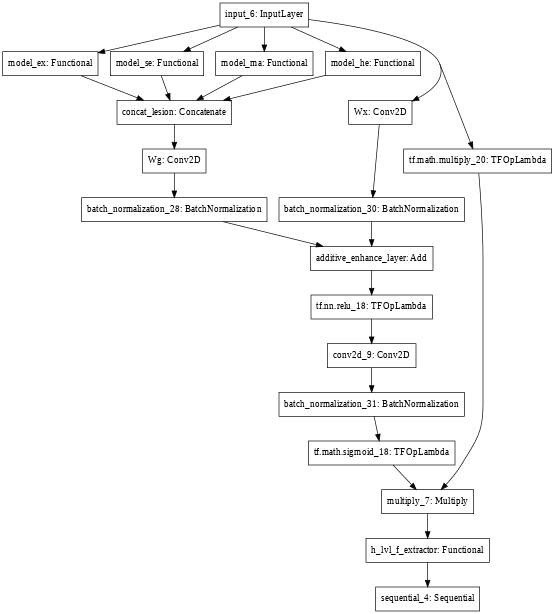

In [136]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [41]:
import keras.backend as K
from keras.callbacks import LambdaCallback
import math
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [ ]:
lr_finder = LRFinder(model)
lr_finder.find(train_images,train_labels, start_lr=1e-6, end_lr=1e-2, batch_size=4, epochs=4)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

Epoch 1/4


In [137]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',  
                        min_delta=0.01)
hist=model.fit(train_generator,steps_per_epoch=len(train_generator) ,
               epochs =20, callbacks = [es,rlr],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/20
150/150 [==============================] - 203s 1s/step - loss: 0.7974 - accuracy: 0.7044 - val_loss: 0.5715 - val_accuracy: 0.7742
Epoch 2/20
150/150 [==============================] - 173s 1s/step - loss: 0.4994 - accuracy: 0.8063 - val_loss: 0.3789 - val_accuracy: 0.8710
Epoch 3/20
150/150 [==============================] - 174s 1s/step - loss: 0.3323 - accuracy: 0.8919 - val_loss: 0.4055 - val_accuracy: 0.8710
Epoch 4/20
150/150 [==============================] - 173s 1s/step - loss: 0.2188 - accuracy: 0.9199 - val_loss: 0.3493 - val_accuracy: 0.8548
Epoch 5/20
150/150 [==============================] - 174s 1s/step - loss: 0.2363 - accuracy: 0.9079 - val_loss: 0.6287 - val_accuracy: 0.8226
Epoch 6/20
150/150 [==============================] - 174s 1s/step - loss: 0.2718 - accuracy: 0.9102 - val_loss: 0.5938 - val_accuracy: 0.7903
Epoch 7/20
150/150 [==============================] - 173s 1s/step - loss: 0.1563 - accuracy: 0.9513 - val_loss: 0.6714 - val_accuracy: 0.8065

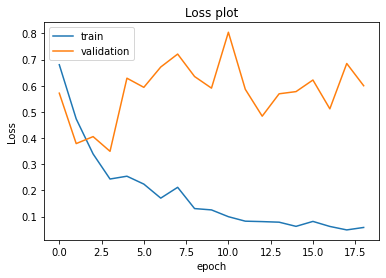

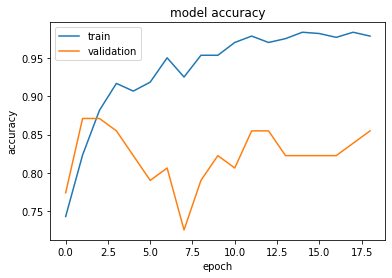

In [138]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [50]:
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

In [102]:
len(val_generator),len(val_generator)*4-2

(16, 62)

[[21  0  1  0  0]
 [ 2  2  0  0  0]
 [ 0  0 14  2  0]
 [ 0  0  3 12  2]
 [ 0  0  0  0  3]]
accuracy  0.8387096774193549  accuracy
quadratic kappa  0.9433909256918106


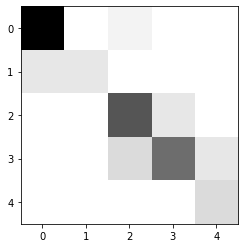

In [191]:
pred_y_=np.zeros((len(val_generator)*4-2,5))
val_y_=np.zeros((len(val_generator)*4-2,5))
for i,(img,lbl) in enumerate(val_generator):
  pred_y_[4*i:4*i+4]=model.predict(img)
  val_y_[4*i:4*i+4,:]=lbl
  # run for loop len(val_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
  if i==15:
    break
pred_y_=pred_y_
cm=confusion_matrix(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print("accuracy ",accuracy_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(val_y_,axis=1)))

(array([22.,  0.,  4.,  0.,  0., 16.,  0., 17.,  0.,  3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

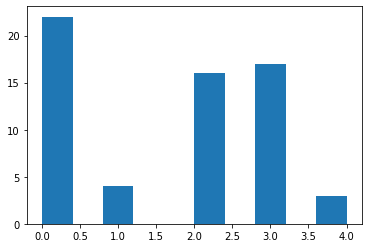

In [192]:
plt.hist(np.argmax(val_y_,axis=1))

## test accuracy

26
[[28  1  4  1  0]
 [ 3  0  2  0  0]
 [ 6  0 19  5  2]
 [ 2  0  4 12  1]
 [ 2  0  3  3  5]]
0.6213592233009708  accuracy
quadratic kappa  0.6592510907608956


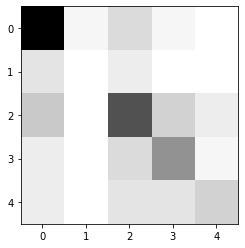

In [139]:
pred_y_=np.zeros((103,5))
print(len(test_generator))
for i in range(len(test_generator)):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

## acc with TTA

[[30  1  3  0  0]
 [ 4  1  0  0  0]
 [ 3  0 22  4  3]
 [ 2  0  4 12  1]
 [ 3  0  1  2  7]]
0.6990291262135923  accuracy
quadratic kappa  0.7088238020205766


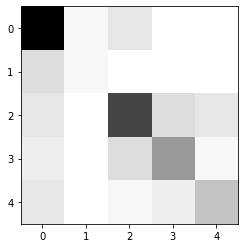

In [195]:
pred_y_tta=np.zeros((len(test_generator)*4-1,5)) #len(test_generator)*4-1=103
test_y_=np.zeros((len(test_generator)*4-1,5))
for i,(img,lbl) in enumerate(test_generator):
  pred_y_tta[4*i:4*i+4]=model.predict(img)
  test_y_[4*i:4*i+4,:]=lbl
  # run for loop len(test_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
  if i==25:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

(array([34.,  0.,  5.,  0.,  0., 32.,  0., 19.,  0., 13.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

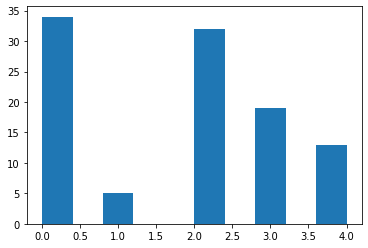

In [109]:
plt.hist(np.argmax(test_y_,axis=1))

## Get attention maps, filtered image


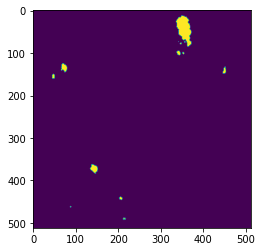

In [172]:
seg_model=model.get_layer(name='model_he') 
plt.imshow(np.squeeze(seg_model(test_images[9:10,:,:,:])[0],axis=2))

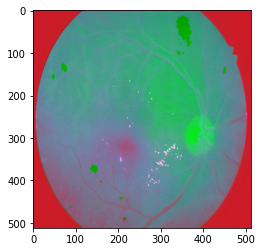

In [189]:
layers_name=[]
index_att_layer=0
count=0
for i in model.layers:
  layers_name.append(i.name)
  if i.name=='tf.math.sigmoid_18':
    index_att_layer=count
  count+=1
att=Model(inputs=model.input,outputs=model.layers[index_att_layer].output) 
attention_map=att(test_images[9:10,:,:,:])
plt.imshow(attention_map[0,:,:,:])#/np.max(attention_map))

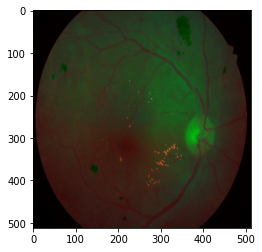

In [185]:
filtered_image=Model(inputs=model.input,outputs=model.layers[-3].output) 
plt.imshow(filtered_image(test_images[9:10,:,:,:])[0,:,:,:]/255)

## save model to disk

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/model_eff4_Late_fusion_Attention_based_lesion.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/model_eff4_Late_fusion_Attention_based_lesion.h5")
print("Saved model to disk")

Saved model to disk


## test on best validation model

In [ ]:
model_1=build_model(5,'EfficientNetB4')
model_1.load_weights("weights.07-0.71.hdf5") 

model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled


[[28  2  4  0  0]
 [ 5  0  0  0  0]
 [ 4  4 19  4  1]
 [ 2  0  6  9  2]
 [ 2  0  3  5  3]]
0.5728155339805825  acuracy
quadratic kappa  0.6789530971699981


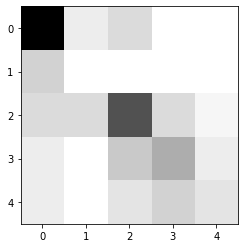

In [ ]:
pred_y_=np.zeros((test_labels.shape))
for i in range(18):
  pred_y_[6*i:6*i+6]=model_1.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

[[25  6  3  0  0]
 [ 3  1  1  0  0]
 [ 3  3 22  3  0]
 [ 2  0  7  7  3]
 [ 1  0  5  2  5]]
0.5882352941176471  accuracy
quadratic kappa  0.7169929850277458


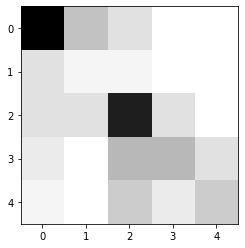

In [ ]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[6*i:6*i+6]=model_1.predict(img)
  test_y_[6*i:6*i+6,:]=lbl
  if i==16:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

In [ ]:
test_y_[-2:],pred_y_tta[-2:]

(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[9.57671523e-01, 4.18191217e-02, 4.65519086e-04, 3.92664915e-05,
         4.39963287e-06],
        [9.27567184e-01, 1.46416007e-02, 3.63852642e-02, 3.45239928e-03,
         1.79534964e-02]]))

In [ ]:
pred_y_tta.shape

(102, 5)